In [4]:
import os
os.chdir("/Users/evanrootness/Project1/EtsyDSProject")
pwd = os.getcwd()
print(pwd)

/Users/evanrootness/Project1/EtsyDSProject


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.optimize as opt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys  

In [5]:
import_data = pd.read_csv(pwd + '/data/art_map.csv')
raw_data = import_data.copy()

In [5]:

# test = pd.read_csv('/kaggle/input/titanic/test.csv')

# training['train_test'] = 1
# test['train_test'] = 0
# test['Survived'] = np.NaN
# all_data = pd.concat([training,test])
# all_data.columns

# Data Exploration

In [181]:
data = raw_data.drop(['web-scraper-order', 'web-scraper-start-url', 'product-href'], axis = 1)

In [11]:
print(data.shape)
data

(64, 6)


,product,name,price,reviews_product,reviews_shop,shop_star_rating
0,My Home is the Sea . giclee art print\n ...,My Home is the Sea . giclee art print,Price:\n $35.00+,107,"9,854",5 out of 5 stars
1,Giclée art print of Abstract painting signed b...,Giclée art print of Abstract painting signed b...,Price:\n $48.45+,48,"1,050",5 out of 5 stars
2,Trout Watercolor Art Print. Blue & Green Water...,Trout Watercolor Art Print. Blue & Green Water...,Price:\n $18.00+,17,"2,781",5 out of 5 stars
3,"Tree rings Print, Three Panel Wall Art, Woodcu...","Tree rings Print, Three Panel Wall Art, Woodcu...",Price:\n $209.60,240,"2,917",5 out of 5 stars
4,"Christmas pysanka Goose egg, Ukrainian Easter ...","Christmas pysanka Goose egg, Ukrainian Easter ...",Price:\n $150.00+,NaN,NaN,5 out of 5 stars
...,...,...,...,...,...,...
59,Family Portrait Illustration Custom Family Por...,Family Portrait Illustration Custom Family Por...,Price:\n $25.22+,131,650,5 out of 5 stars
60,Pet Portrait Custom Dog Portrait Personalize P...,Pet Portrait Custom Dog Portrait Personalize P...,Price:\n $7.09+,100,"2,485",5 out of 5 stars
61,"watercolor painting from photo, custom dog por...","watercolor painting from photo, custom dog por...",Price:\n $18.75+,"1,024","6,155",5 out of 5 stars
62,"Pet Painting, Watercolor Pet Portrait, Pet Mem...","Pet Painting, Watercolor Pet Portrait, Pet Mem...",Price:\n $29.95+,697,"4,852",5 out of 5 stars


In [16]:
data.describe()

,product,name,price,reviews_product,reviews_shop,shop_star_rating
count,64,64,64,61,61,64
unique,64,64,47,52,43,2
top,My Home is the Sea . giclee art print\n ...,My Home is the Sea . giclee art print,Price:\n $18.00+,71,"2,781",5 out of 5 stars
freq,1,1,8,2,7,62


In [182]:
data.rename(columns={'shop_star_rating': 'stars'}, inplace=True)

In [183]:
data.fillna(value='0', inplace=True)

In [14]:
# # distributions for all numeric variables 
# length_df_num = len(raw_data.iloc[0, :])
# width = 5
# height = math.ceil(length_df_num / width)
# row = 1
# row_index = 0
# column_index = 0
# plt.figure(figsize = (14, 14))
# for i in raw_data.columns:
#     ax = plt.subplot2grid((height, width), (row_index, column_index))
#     # ax.bar(raw_data[i], height=raw_data['GRADE'])
#     ax.hist(raw_data[i])
#     ax.set_title(i)
#     if ((column_index + 1) % width == 0): #0, 1, 2, 3      4, 5, 6, 7
#         row_index += 1
#         column_index = 0
#     else:
#         column_index += 1

1 (age), 2 (gender), 5 (additional work), 18 (reading freq lit, 22 (class attendance), 26 (listening in class), 27 (discussion interest), 29 (GPA first sem), 30 (expected GPA),books) 

In [76]:
# print(data.iloc[:, 2])
# print(data.add(data.iloc[:, 2]))

In [184]:
data = data.astype(dtype='string')

In [185]:
data.dtypes

product            string[python]
name               string[python]
price              string[python]
reviews_product    string[python]
reviews_shop       string[python]
stars              string[python]
dtype: object

In [186]:
data_num = pd.DataFrame(data={'price': data['price'], 'reviews_product': data['reviews_product'], 
                              'reviews_shop': data['reviews_shop'], 'stars': data['stars']})
data_num

,price,reviews_product,reviews_shop,stars
0,Price: $35.00+,107,"9,854",5 out of 5 stars
1,Price: $48.45+,48,"1,050",5 out of 5 stars
2,Price: $18.00+,17,"2,781",5 out of 5 stars
3,Price: $209.60,240,"2,917",5 out of 5 stars
4,Price: $150.00+,0,0,5 out of 5 stars
...,...,...,...,...
59,Price: $25.22+,131,650,5 out of 5 stars
60,Price: $7.09+,100,"2,485",5 out of 5 stars
61,Price: $18.75+,"1,024","6,155",5 out of 5 stars
62,Price: $29.95+,697,"4,852",5 out of 5 stars


In [175]:
import re
name = "price: $48.00"
test = re.search('[^\$]*$', name)
print(test)
print(test.group(0))

<re.Match object; span=(8, 13), match='48.00'>
48.00


In [187]:
for i in range(len(data_num['price'])):
    data_num['price'][i] = re.search('[^+]*', data_num['price'][i]).group(0)
    print(data_num['price'][i])
    data_num['price'][i] = re.search('[^\$]*$', data_num['price'][i]).group(0)
    print(data_num['price'][i])
data_num['price']

Price:
        $35.00
35.00
Price:
        $48.45
48.45
Price:
        $18.00
18.00
Price:
        $209.60
209.60
Price:
        $150.00
150.00
Price:
        $16.00
16.00
Price:
        $73.31
73.31
Price:
        $48.00
48.00
Price:
        $35.00
35.00
Price:
        $35.00
35.00
Price:
        $18.00
18.00
Price:
        $18.00
18.00
Price:
        $19.50
19.50
Price:
        $45.00
45.00
Price:
        $16.80
16.80
Price:
        $94.00
94.00
Price:
        $87.40
87.40
Price:
        $15.00
15.00
Price:
        $45.00
45.00
Price:
        $37.49
37.49
Price:
        $18.00
18.00
Price:
        $18.00
18.00
Price:
        $22.50
22.50
Price:
        $27.00
27.00
Price:
        $179.40
179.40
Price:
        $35.00
35.00
Price:
        $18.00
18.00
Price:
        $17.00
17.00
Price:
        $17.11
17.11
Price:
        $13.59
13.59
Price:
        $11.24
11.24
Price:
        $21.60
21.60
Price:
        $18.00
18.00
Price:
        $17.00
17.00
Price:
        $16.00
16.00
Price:
       

0      35.00
1      48.45
2      18.00
3     209.60
4     150.00
       ...  
59     25.22
60      7.09
61     18.75
62     29.95
63     18.77
Name: price, Length: 64, dtype: string

Pause

In [188]:
sns.heatmap(data_num.iloc[:, 1:].corr())

ValueError: could not convert string to float: '4,682'

In [107]:
female_avg = raw_data.query("`2` == 1").loc[:, 'GRADE'].mean()
male_avg = raw_data.query("`2` == 2").loc[:, 'GRADE'].mean()
plt.figure(figsize = (12, 3))
ax = plt.subplot(131)
plt.bar(x = np.arange(1, 3), height = [female_avg, male_avg])

UndefinedVariableError: name 'BACKTICK_QUOTED_STRING_2' is not defined

[2.40740741 3.32323232 3.89473684]


<BarContainer object of 3 artists>

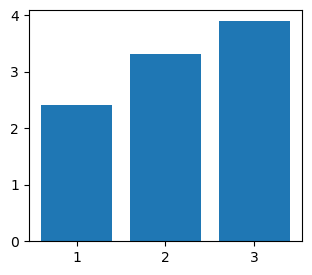

In [14]:
def avg_grades_one_column(data, column, num_choices):
    array = np.array([])
    for i in np.arange(num_choices):
        array = np.append(array, data.query(f"`{column}` == {i + 1}").loc[:, 'GRADE'].mean())
    return array

# 18 reading freq non-scientific
avg_grades_read_nonsci = avg_grades_one_column(raw_data, 18, 3)
print(avg_grades_read_nonsci)

plt.figure(figsize = (12, 3))
ax = plt.subplot(131)
plt.bar(x = np.arange(1, len(avg_grades_read_nonsci) + 1), height = avg_grades_read_nonsci)

In [18]:
sys.path.insert(1, '/Users/evanrootness/Project1/ProjectTwo/py_scripts/')
import explore

['/Users/evanrootness/Project1/ProjectTwo/notebooks_exploration', '/Users/evanrootness/Project1/ProjectTwo/py_scripts/', '/Users/evanrootness/anaconda3/lib/python311.zip', '/Users/evanrootness/anaconda3/lib/python3.11', '/Users/evanrootness/anaconda3/lib/python3.11/lib-dynload', '', '/Users/evanrootness/anaconda3/lib/python3.11/site-packages', '/Users/evanrootness/anaconda3/lib/python3.11/site-packages/aeosa']


In [77]:
raw_data.query('`27` == 1').loc[:, "GRADE"]

0      1
2      1
5      2
67     1
80     4
108    6
113    1
114    2
121    0
Name: GRADE, dtype: int64

[2.28787879 3.         6.125      4.5        5.28571429]


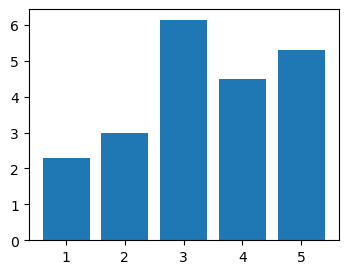

In [86]:
test_corr = explore.avg_grades_one_column(raw_data, 'COURSE ID', 5)
plt.figure(figsize = (4, 3))
plt.bar(x = np.arange(1, len(test_corr) + 1), height = test_corr)
print(test_corr)

In [112]:
x = raw_data[['1', '2', '5', '18', '22', '26', '27', '29', '30']]
y = raw_data['GRADE']

In [154]:
raw_data.query('GRADE == 0')

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
9,STUDENT10,2,1,2,3,2,2,1,3,4,...,1,1,2,2,2,2,1,2,1,0
11,STUDENT12,1,1,1,4,1,1,2,4,2,...,3,2,3,1,3,3,4,3,1,0
12,STUDENT13,1,1,1,4,2,2,2,1,1,...,1,1,2,2,2,3,4,2,1,0
121,STUDENT122,2,1,2,3,1,1,1,1,2,...,2,1,1,1,1,1,1,1,8,0
128,STUDENT129,1,1,2,4,2,1,1,1,4,...,1,1,3,2,2,1,2,2,9,0
136,STUDENT137,1,1,2,3,1,1,1,1,2,...,3,1,3,2,2,1,2,2,9,0
138,STUDENT139,1,1,2,4,1,1,1,5,2,...,2,1,3,2,3,1,1,3,9,0
139,STUDENT140,1,1,2,4,1,2,1,2,2,...,2,1,2,3,2,1,1,2,9,0


In [198]:
x_train, xtest, y_train, ytest = train_test_split(raw_data[['1', '2', '5', '18', '22', '26', '27', '29', '30']], 
                                                  raw_data['GRADE'], test_size=0.2, random_state=15)

Which columns do I want to use?
1 (age), 2 (gender), 5 (additional work), 18 (reading freq lit, 22 (class attendance), 26 (listening in class), 27 (discussion interest), 29 (GPA first sem), 30 (expected GPA),books) 

In [199]:
print(y_train[y_train == 0])
# y_train(y_train > 0)
# print(y_train)
# y_train.dropna()


12     0
11     0
136    0
121    0
139    0
128    0
Name: GRADE, dtype: int64


In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [202]:
# Bayesian
gnb = GaussianNB()
cv = cross_val_score(gnb, x_train, y_train, cv=5)
print(cv)
print(cv.mean())

[0.08333333 0.17391304 0.08695652 0.13043478 0.26086957]
0.1471014492753623


In [204]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, x_train, y_train, cv=6)
print(cv)
print(cv.mean())

[0.15       0.3        0.36842105 0.21052632 0.21052632 0.26315789]
0.25043859649122807


In [221]:
# Scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

data_scaled = raw_data.copy()
data_scaled[['1', '2', '5', '18', '22', '26', '27', '29', '30']]= scale.fit_transform(data_scaled[['1', '2', '5', '18', '22', '26', '27', '29', '30']])
data_scaled

x_train, xtest, y_train, ytest = train_test_split(data_scaled[['1', '2', '5', '18', '22', '26', '27', '29', '30']], 
                                                  raw_data['GRADE'], test_size=0.3, random_state=15)#, stratify=y_train)

In [219]:
# Bayesian
gnb = GaussianNB()
cv = cross_val_score(gnb, x_train, y_train, cv=2)
print(cv)
print(cv.mean())

[0.2745098 0.2      ]
0.23725490196078433


In [207]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, x_train, y_train, cv=6)
print(cv)
print(cv.mean())

[0.2        0.3        0.31578947 0.21052632 0.21052632 0.26315789]
0.24999999999999997
